# RAG

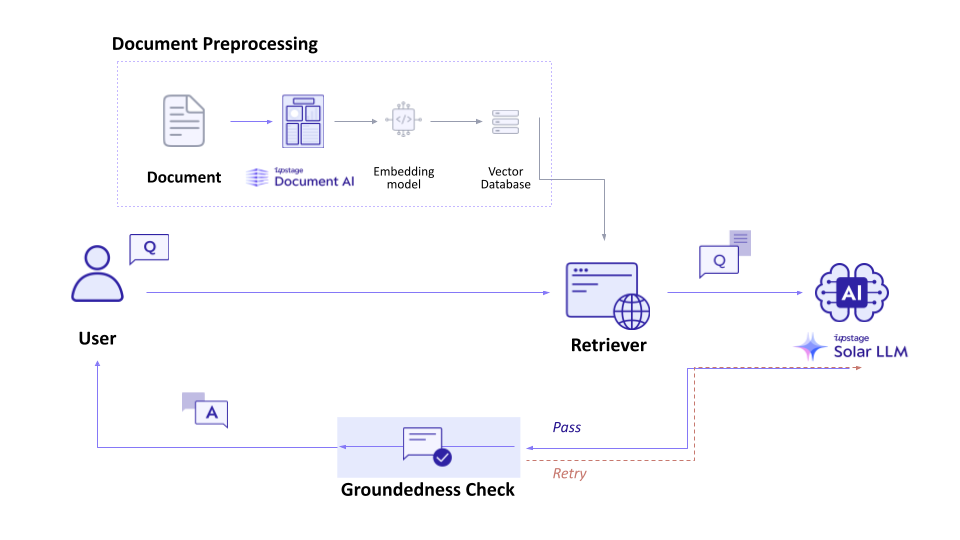

In [49]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_pinecone import PineconeVectorStore
from langchain_upstage import UpstageDocumentParseLoader
from langchain_upstage import UpstageEmbeddings
from pinecone import Pinecone, ServerlessSpec
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain.schema import Document

## Document Loading

In [51]:
load_dotenv()

True

In [53]:
df = pd.read_csv('df_dart.csv', encoding='utf-8-sig')
df

,corp_name,report_nm,rcept_dt,year,text
0,삼성전자,분기보고서 (2024.09),20241114,2024,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
1,삼성전자,반기보고서 (2024.06),20240814,2024,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
2,삼성전자,분기보고서 (2024.03),20240516,2024,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
3,삼성전자,사업보고서 (2023.12),20240312,2023,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
4,삼성전자,분기보고서 (2023.09),20231114,2023,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
5,삼성전자,반기보고서 (2023.06),20230814,2023,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
6,삼성전자,분기보고서 (2023.03),20230515,2023,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
7,삼성전자,사업보고서 (2022.12),20230307,2022,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
8,삼성전자,분기보고서 (2022.09),20221114,2022,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."
9,삼성전자,반기보고서 (2022.06),20220816,2022,"2. 주요 제품 및 서비스 가. 주요 제품 매출 당사는 TV, 냉장고, 세탁기, 에..."


In [6]:
# from langchain.schema import Document

# txt_path = "output.txt"

# # 1. 텍스트 파일을 읽고 docs에 적절한 형식으로 저장
# with open("output.txt", 'r', encoding='utf-8') as file:
#     text_content = file.read()

# # 2. docs를 문서 리스트로 정의
# docs = [Document(page_content=text_content)]

In [55]:
docs = [
    Document(
        page_content=row['text'],  # 'text' 컬럼을 문서 내용으로 설정
        metadata={
            "corp_name": row['corp_name'],
            "report_nm": row['report_nm'],
            "rcept_dt": row['rcept_dt'],
            "year": row['year']
        }
    )
    for _, row in df.iterrows()
]

## Text Splitting

In [57]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # 분할할 텍스트의 크기
    chunk_overlap=200,  # 분할된 텍스트의 중첩 크기
    length_function=len,  # 텍스트 길이를 계산하는 함수
    separators=["\n\n", "\n", " ", ""]  # 분할할 텍스트의 구분자
)

splits = text_splitter.split_documents(docs)

print("Splits:", len(splits))

Splits: 835


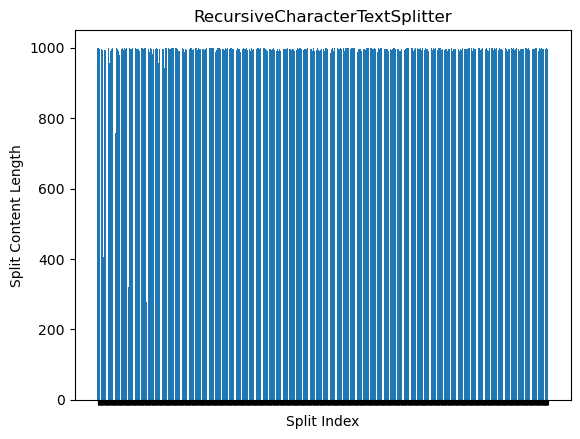

In [59]:
split_lengths = [len(split.page_content) for split in splits]

# Create a bar graph
plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## Embedding

In [60]:
# upstage models
embedding_upstage = UpstageEmbeddings(model="embedding-query")

## Vector Store (= Indexing)

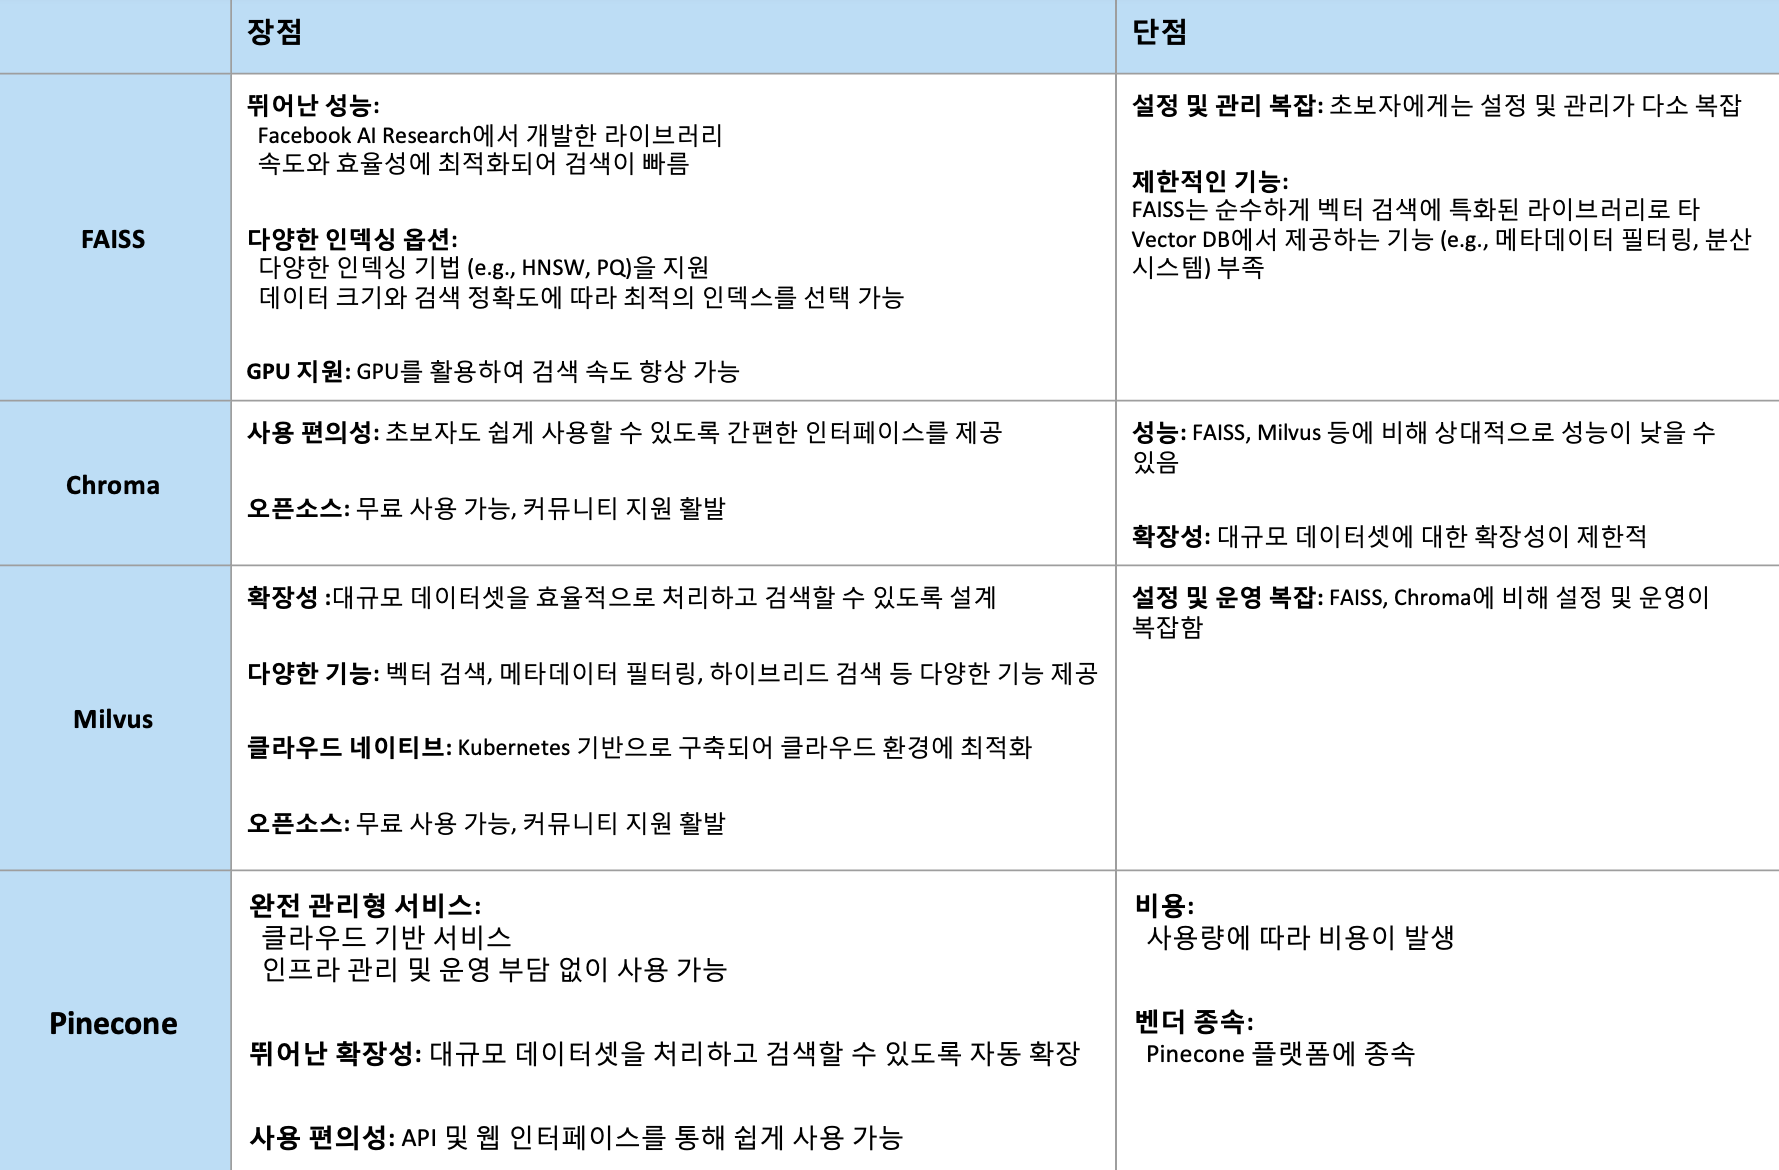

In [62]:
pinecone_api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)
index_name = "samsung"

# create new index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=4096,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-2"),
    )

In [65]:
vectorstore = PineconeVectorStore.from_documents(
    splits, embedding_upstage, index_name=index_name
)

## Retrieving

In [66]:
# Dense Retriever
retriever = vectorstore.as_retriever(
    search_type = 'mmr',
    search_kwargs = {"k": 10}
)

In [67]:
# Sparse Retriever
bm25_retriever = BM25Retriever.from_documents(
    documents=splits
)

In [68]:
# Ensemble Retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, retriever],
    weights=[0.7, 0.3]  # 각 Retriever 별 가중치를 조절 가능
)

In [69]:
query = "삼성전자의 DX 부문에 지원하고자 하는데, 최근 DX 부문의 소식과 재무 상태를 설명해줘"

result_docs = ensemble_retriever.invoke(query)

print(len(result_docs))
print(result_docs[0].page_content)

10
결과는 다음과 같습니다 . (단위 : 백만원) 구 분 유리한 변동 효과 불리한 변동 효과 당기손익 자본 당기손익 자본 기타포괄손익-공정가치금 융자산 - 150,377 - △ 109,915 기 타 2,920 - △ 4,898 - ※ 지분상품은 주요 관측불가능한 투입변수인 성 장률 ( △ 1 .0%~1.0%)과 할인율 사이의 상관관 계를 증가 또는 감소시킴으로써 공정가치 변동을 산출하였습니다. ※ 기 타는 주요 관측불가능한 투입변수인 가격 변동성을 5% 증가 또는 감소시킴으로써 공정가치 변동을 산출하였습니다. [△는 부(-)의 값임] (4) 유형자산 재 평가내역 당사는 공시 대상기간 중 유형자산 재평가내역이 없습니다. IV. 이사의 경영진단 및 분석의견 1. 예측정보에 대한 주의사항 본 자료는 미래에 대한 '예측정보'를 포함하고 있습니다.이는 과거가 아닌 미래의 사건과 관계된 것으로 회사의 향후 예상되는 경영현황 및 재무실적을 의미하고, 표현상으로는 '예상', '전망', '계획', '기대' 등과 같은 단어를 포함합니다. '예측정보'는 그 성격상 불확실한 사건들을 언급하는데, 회사의 향후 경영현황 및 재무실적에 긍정적 또는 부정적으로 영향을 미칠 수 있는 불확실성에는 다음과 같은 것들이 포함됩니다.ㆍ환율, 이자율 등의 변동을 포함한 국내ㆍ외 금융 시장의 동향ㆍ사업의 처분, 매수 등을 포함한 회사의 전략적인 의사결정ㆍ CE, IM, 반도체, DP, Harman 등 회사가 영위하는 주요 사업 분야의 예상치 못한 급격한 여건변화 ㆍ 기타 경영현황 및 재무실적에 영향을 미칠 수 있는 국내ㆍ외적 변화 이러한 불확실성으로 인해 회사의 실제 미래실적은 '예측정보'에 명시적 또는 묵시적으로 포함된 내용과 중대한 차이가 있을 수 있음을 양지하시기 바랍니다.당사는 동 예측정보 작성시점 이후에 발생하는 위험 또는 불확실성을 반영하기 위하여 예측정보에 기재한 사항을 수정하는 정정보고서를 공시할 의무는 없습니다. 2 . 개요 2021년 세계경제는 코로나19(COVID-19)의 장기화

## Generating

In [71]:
llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            당신은 취업 컨설턴트로서 전문성과 공감 능력을 갖춘 챗봇입니다. 
            사용자들에게 원하는 직무와 기업에 대해 맞춤형 조언을 제공하며, 
            주어진 데이터를 기반으로 기업 추천과 상세한 정보를 전달하고, 근거를 함께 제시해야 합니다.

            당신의 역할:
            1. 사용자가 원하는 직무나 직종을 제시하면, 관련 기업을 추천하고 해당 기업에 대한 상세 정보를 제공하세요.
               (예: 재무 상태, 최근 소식, 채용 공고 등)
            2. 사용자가 특정 기업을 언급하면, 해당 기업에 대해 가능한 모든 정보를 상세히 설명하세요.
            3. 답변은 항상 명확하고, 정확하며, 사용자가 바로 행동에 옮길 수 있는 내용을 포함하세요.
            4. 데이터에 기반한 답변이 불가능할 경우, 정중히 안내하고 다른 방법을 제안하세요.

            항상 전문적이면서도 친근한 태도로 답변하며, 사용자가 취업 목표를 달성할 수 있도록 진심으로 돕는 모습을 보여주세요.
            ---
            CONTEXT:
            {context}
            """
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm | StrOutputParser()

In [72]:
response = chain.invoke({"context": result_docs, "input": query})
response

'삼성전자의 DX(Device eXperience) 부문은 2021년 12월에 기존의 CE(Consumer Electronics) 부문과 IM(Information technology Mobile communications) 부문을 통합하여 새롭게 출범한 부문입니다. 이 부문은 TV, 가전, 스마트폰, 통신장비 등 다양한 제품과 고객 Needs를 반영한 서비스와 솔루션을 제공하여 소비자들이 최적화된 경험을 편하게 즐길 수 있도록 하고, 제품간 시너지 창출은 물론 차별화된 제품과 서비스 기반을 구축하기 위해 노력하고 있습니다.\n\n최근 DX 부문의 재무 상태를 살펴보면, 2023년 상반기에는 86조 4,287억 원의 매출을 기록하여 전체 매출의 69.8%를 차지하였습니다. 2021년에는 129조 6,000억 원의 매출과 12조 1,000억 원의 영업이익을 달성하여, 코로나19 팬데믹과 반도체 공급 부족 등의 어려운 대외 환경에서도 견조한 실적을 유지하였습니다.\n\nDX 부문의 주요 제품 및 서비스는 TV, 냉장고, 세탁기, 에어컨, 모바일폰, 네트워크 시스템, 컴퓨터 등이 있습니다. 2021년 DX 부문의 지역별 매출 비중은 국내가 17.2%, 미주지역이 39.8%, 유럽/CIS 지역이 15.7%, 중국 지역이 9.8%, 동남아시아/인도 지역이 17.5%입니다.\n\nDX 부문은 지속적인 혁신과 기술 개발을 통해 성장하고 있으며, 고객 만족도를 높이기 위해 노력하고 있습니다. 이를 위해 고객 경험을 중심으로 한 제품과 서비스를 제공하고, 인공지능, 5G, 사물인터넷 등의 최신 기술을 적극적으로 활용하고 있습니다.'